In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam, SGD
import keras

C:\Users\admin\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
from glob import glob
import pandas as pd

data = pd.read_csv('C:/Users/admin/Desktop/xray dataset/Data_Entry_2017.csv')
data = data[data['Patient Age'] < 100]  # removing datapoints which have age greater than 100

image_dir = 'C:/Users/admin/Desktop/xray dataset'

image_pattern = os.path.join(image_dir, "images*", "*", "*.png")

image_paths = glob(image_pattern)

data_image_paths = {os.path.basename(x): x for x in image_paths}

data['path'] = data['Image Index'].map(data_image_paths.get)

data['Patient Age'] = data['Patient Age'].map(int)

print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])

data.sample(10)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
103252,00027533_008.png,No Finding,8,27533,68,M,AP,3056,2544,0.139,0.139,NaN,C:/Users/admin/Desktop/xray dataset\images_011...
12835,00003369_002.png,Atelectasis|Effusion,2,3369,50,F,AP,2500,2048,0.168,0.168,NaN,C:/Users/admin/Desktop/xray dataset\images_002...
26176,00006873_000.png,Effusion|Pleural_Thickening,0,6873,35,M,PA,2048,2500,0.171,0.171,NaN,C:/Users/admin/Desktop/xray dataset\images_004...
72591,00017894_000.png,No Finding,0,17894,31,F,AP,2500,2048,0.168,0.168,NaN,C:/Users/admin/Desktop/xray dataset\images_008...
101359,00026925_017.png,Infiltration,17,26925,38,F,AP,2544,3056,0.139,0.139,NaN,C:/Users/admin/Desktop/xray dataset\images_011...
79039,00019395_026.png,Atelectasis|Effusion|Infiltration,26,19395,34,F,PA,2992,2991,0.143,0.143,NaN,C:/Users/admin/Desktop/xray dataset\images_009...
14779,00003861_001.png,No Finding,1,3861,12,M,PA,2048,2500,0.171,0.171,NaN,C:/Users/admin/Desktop/xray dataset\images_002...
52295,00013206_001.png,No Finding,1,13206,13,F,PA,2992,2991,0.143,0.143,NaN,C:/Users/admin/Desktop/xray dataset\images_006...
54010,00013615_021.png,Atelectasis|Cardiomegaly|Infiltration,21,13615,10,F,AP,2500,2048,0.168,0.168,NaN,C:/Users/admin/Desktop/xray dataset\images_006...
99391,00026292_000.png,Atelectasis,0,26292,74,M,PA,2992,2991,0.143,0.143,NaN,C:/Users/admin/Desktop/xray dataset\images_011...


In [3]:
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

data.sample(10)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
80766,00019850_001.png,Emphysema,1,19850,60,F,AP,3056,2364,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101,00002625_000.png,,0,2625,43,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83775,00020584_000.png,Mass,0,20584,56,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
35660,00009396_001.png,,1,9396,28,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49136,00012470_001.png,Mass,1,12470,15,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74216,00018237_016.png,,16,18237,30,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92170,00023022_000.png,,0,23022,19,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54444,00013659_026.png,Infiltration,26,13659,64,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
49444,00012543_012.png,,12,12543,64,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80201,00019708_002.png,,2,19708,58,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19891), ('Mass', 5779), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


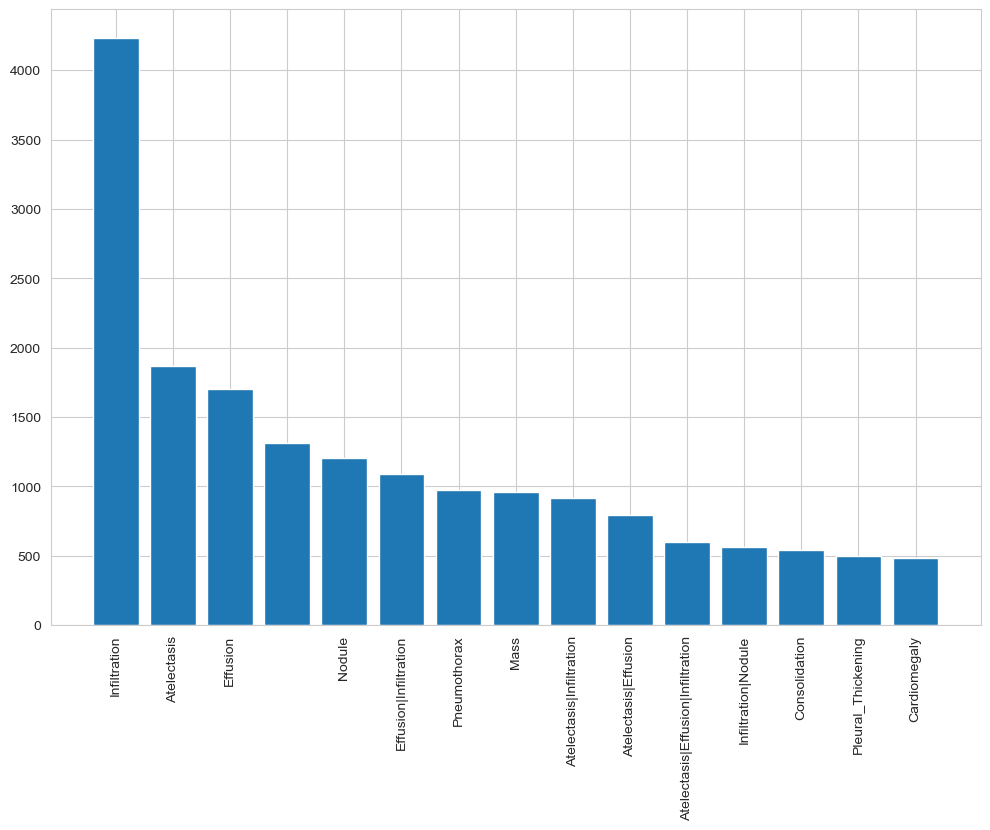

In [5]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.04 + number of findings
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(30000, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [6]:
# creating vector of diseases
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

Splitting the data into train and test set

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 2000,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 24000 test 6000


In [8]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2000,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 21600 valid 2400


In [9]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
IMG_SIZE = (224, 224)
core_idg_dense = ImageDataGenerator()

In [65]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="path",
    y_col=all_labels,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='raw')

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="path",
    y_col=all_labels,
    target_size=IMG_SIZE,
    batch_size=64,
    class_mode='raw')

Found 21600 validated image filenames.
Found 2400 validated image filenames.


In [12]:
train_steps_per_epoch = train_df.shape[0] // 32
valid_steps_per_epoch = valid_df.shape[0] // 32

In [83]:
def load_and_preprocess_images(df, batch_size, target_size=(224, 224)):
    num_samples = df.shape[0]
    for batch_start in range(0, num_samples, batch_size):
        batch_end = min(batch_start + batch_size, num_samples)
        batch_df = df.iloc[batch_start:batch_end]

        batch_X = []
        batch_Y = np.zeros((batch_df.shape[0], len(all_labels)))  # Initialize batch_Y
        
        for i, file_path in enumerate(batch_df['path']):
            img = load_and_preprocess_images(file_path, target_size)
            batch_X.append(img)
            
            # Assign one-hot encoded labels directly to batch_Y
            batch_Y[i] = batch_df[all_labels].values[i]
        
        # Convert batch_X to numpy array
        batch_X = np.array(batch_X)
        
        yield batch_X, batch_Y

test_batch_size = 1024
test_generator = load_and_preprocess_images(test_df, batch_size=test_batch_size)
test_X, test_Y = next(test_generator)

In [84]:
test_Y.shape

(1024, 13)

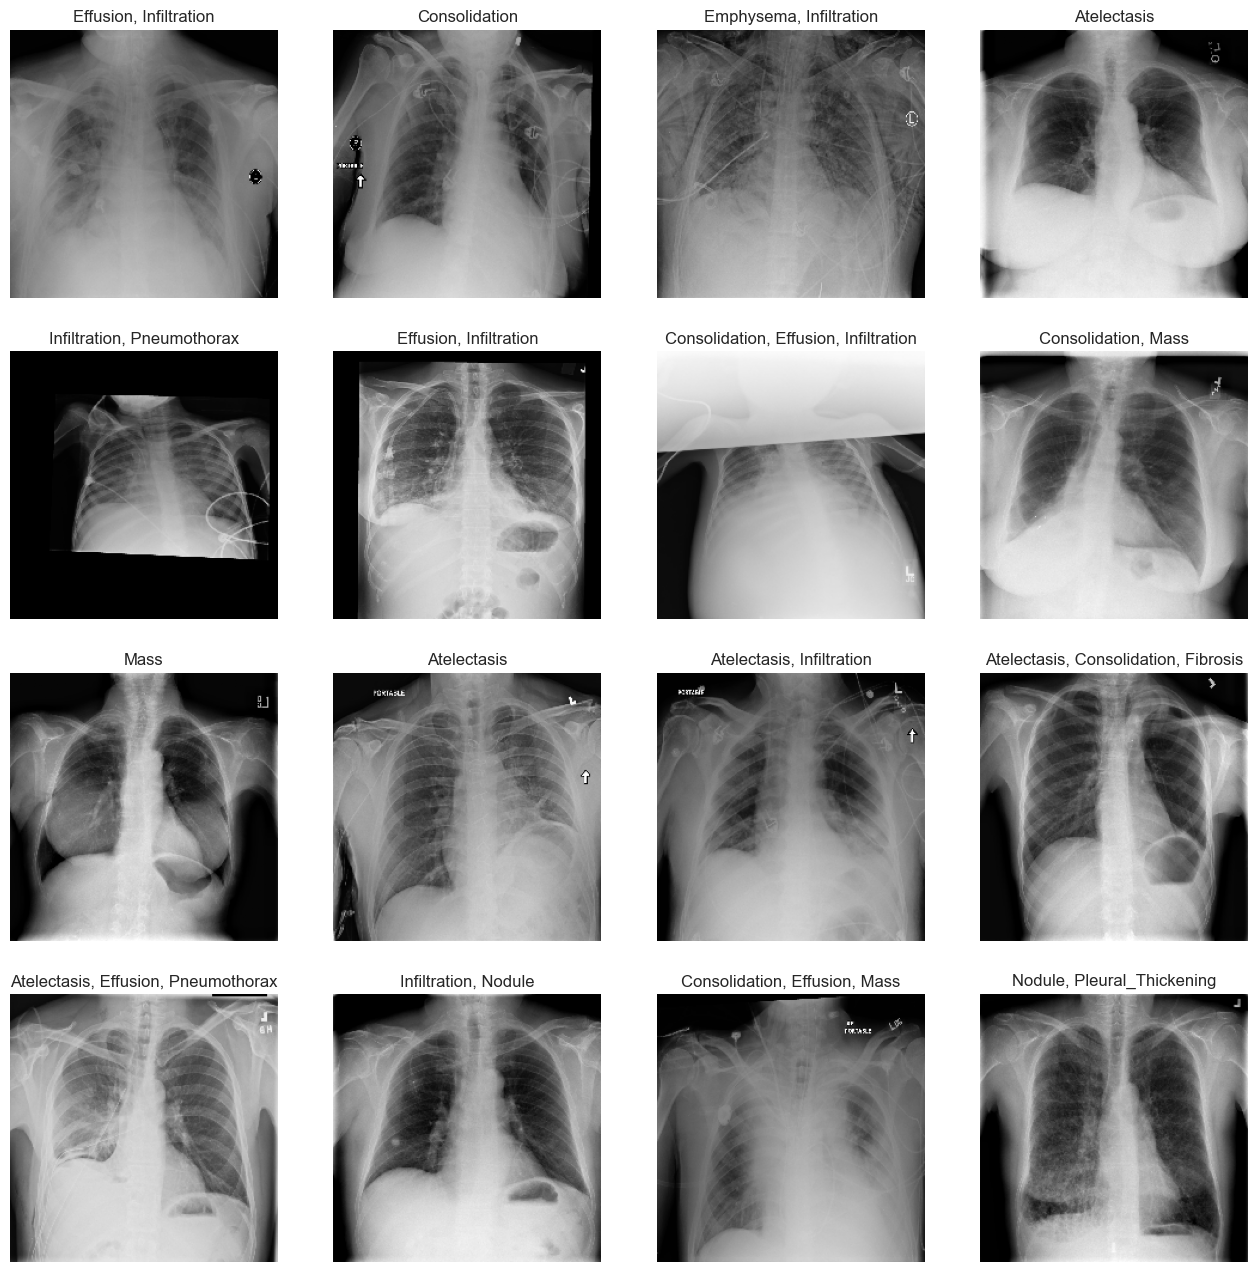

In [19]:
fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))

# Iterate over each image and its corresponding labels
for (c_x, c_y, c_ax) in zip(test_X, test_Y, m_axs.flatten()):
    if len(c_x.shape) == 2:  # Grayscale image
        c_ax.imshow(c_x, cmap='gray')
    else:  # Color image
        c_ax.imshow(c_x)
        
    # Set title with labels where the confidence score is greater than 0.5
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score > 0.5]))
    c_ax.axis('off')

plt.show()

### Creating a CNN Model from scratch

In [222]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(all_labels), activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

In [23]:
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

**Training the model**

In [26]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch, epochs=5,
                    validation_data=valid_generator,
                    validation_steps=valid_steps_per_epoch,
                    verbose=1)

Epoch 1/5


675/675 [==============================] - 3672s 5s/step - loss: 0.6664 - binary_accuracy: 0.7425 - val_loss: 0.6395 - val_binary_accuracy: 0.8677
Epoch 2/5
675/675 [==============================] - 2354s 3s/step - loss: 0.6076 - binary_accuracy: 0.8513 - val_loss: 0.5642 - val_binary_accuracy: 0.8694
Epoch 3/5
675/675 [==============================] - 2133s 3s/step - loss: 0.5165 - binary_accuracy: 0.8628 - val_loss: 0.4555 - val_binary_accuracy: 0.8694
Epoch 4/5
675/675 [==============================] - 2221s 3s/step - loss: 0.4257 - binary_accuracy: 0.8638 - val_loss: 0.3801 - val_binary_accuracy: 0.8694
Epoch 5/5
675/675 [==============================] - 2420s 4s/step - loss: 0.3836 - binary_accuracy: 0.8639 - val_loss: 0.3551 - val_binary_accuracy: 0.8694


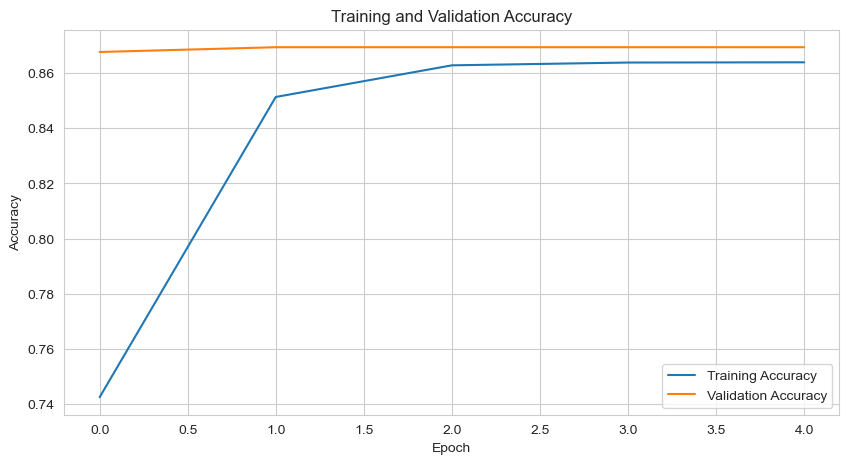

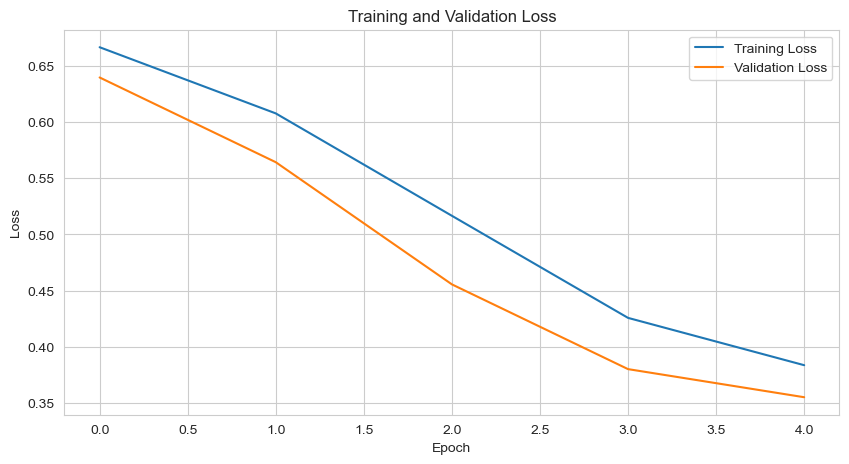

In [29]:
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [153]:
test_Y_arg = np.argmax(test_Y, axis=1)
y_pred_prob = model.predict(test_X)
y_pred = np.argmax(y_pred_prob, axis=1)  

32/32 [==============================] - 68s 464ms/step


In [154]:
print(classification_report(test_Y_arg, y_pred, target_names=all_labels))

                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       307
      Cardiomegaly       0.00      0.00      0.00        48
     Consolidation       0.00      0.00      0.00        74
             Edema       0.00      0.00      0.00        36
          Effusion       0.00      0.00      0.00       160
         Emphysema       0.00      0.00      0.00        27
          Fibrosis       0.00      0.00      0.00        26
      Infiltration       0.19      1.00      0.32       197
              Mass       0.00      0.00      0.00        50
            Nodule       0.00      0.00      0.00        42
Pleural_Thickening       0.00      0.00      0.00        20
         Pneumonia       0.00      0.00      0.00         4
      Pneumothorax       0.00      0.00      0.00        33

          accuracy                           0.19      1024
         macro avg       0.01      0.08      0.02      1024
      weighted avg       0.04      0.1

In [155]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_Y_arg, y_pred))

[[  0   0   0   0   0   0   0 307   0   0   0   0   0]
 [  0   0   0   0   0   0   0  48   0   0   0   0   0]
 [  0   0   0   0   0   0   0  74   0   0   0   0   0]
 [  0   0   0   0   0   0   0  36   0   0   0   0   0]
 [  0   0   0   0   0   0   0 160   0   0   0   0   0]
 [  0   0   0   0   0   0   0  27   0   0   0   0   0]
 [  0   0   0   0   0   0   0  26   0   0   0   0   0]
 [  0   0   0   0   0   0   0 197   0   0   0   0   0]
 [  0   0   0   0   0   0   0  50   0   0   0   0   0]
 [  0   0   0   0   0   0   0  42   0   0   0   0   0]
 [  0   0   0   0   0   0   0  20   0   0   0   0   0]
 [  0   0   0   0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   0   0   0   0  33   0   0   0   0   0]]


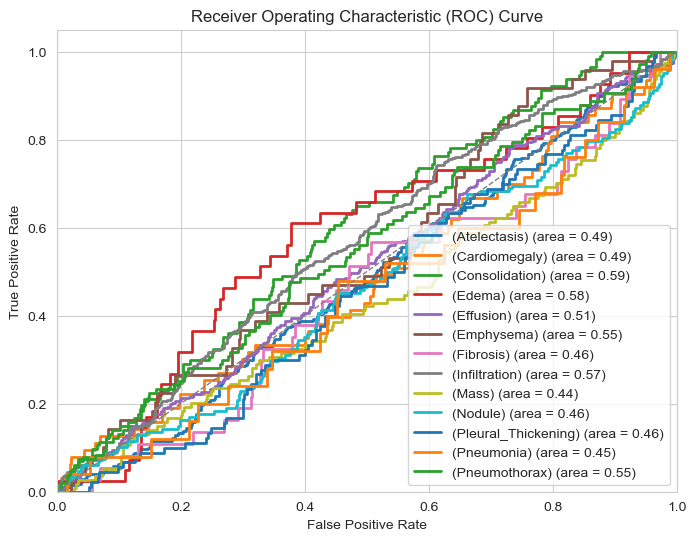

In [161]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(all_labels)):
    fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(all_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label='({}) (area = {:.2f})'.format(all_labels[i], roc_auc[i]))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Using pre-trained model MobileNetV2

In [209]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [236]:
model_pretrained = Sequential([
           base_model,  # Base MobileNet model
           Conv2D(128, (3,3), activation='relu'),
           MaxPooling2D((2,2)),
           GlobalAveragePooling2D(),
           Dense(512, activation='relu'),
           Dropout(0.5),
           Dense(len(all_labels), activation='softmax') 
])

In [237]:
# Set the base model's layers as non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [238]:
# Compile the model
model_pretrained.compile(optimizer='Adam', 
                         loss='binary_crossentropy', 
                         metrics=['binary_accuracy'])

In [239]:
model_pretrained.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 5, 128)         1474688   
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 2, 2, 128)         0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_1  (None, 128)               0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_48 (Dense)            (None, 512)               66048     
                                                     

In [240]:
# Train the model
history_pretrained = model_pretrained.fit(train_generator,
                                epochs=10,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=valid_generator,
                                validation_steps=valid_steps_per_epoch,
                                verbose=1)

Epoch 1/10
675/675 [==============================] - 2033s 3s/step - loss: 0.3530 - binary_accuracy: 0.8678 - val_loss: 0.3273 - val_binary_accuracy: 0.8697
Epoch 2/10
675/675 [==============================] - 1727s 3s/step - loss: 0.3336 - binary_accuracy: 0.8690 - val_loss: 0.3250 - val_binary_accuracy: 0.8700
Epoch 3/10
675/675 [==============================] - 1593s 2s/step - loss: 0.3280 - binary_accuracy: 0.8699 - val_loss: 0.3299 - val_binary_accuracy: 0.8704
Epoch 4/10
675/675 [==============================] - 1615s 2s/step - loss: 0.3258 - binary_accuracy: 0.8700 - val_loss: 0.3228 - val_binary_accuracy: 0.8704
Epoch 5/10
675/675 [==============================] - 1573s 2s/step - loss: 0.3239 - binary_accuracy: 0.8703 - val_loss: 0.3218 - val_binary_accuracy: 0.8700
Epoch 6/10
675/675 [==============================] - 1582s 2s/step - loss: 0.3231 - binary_accuracy: 0.8704 - val_loss: 0.3221 - val_binary_accuracy: 0.8700
Epoch 7/10
675/675 [==============================] 

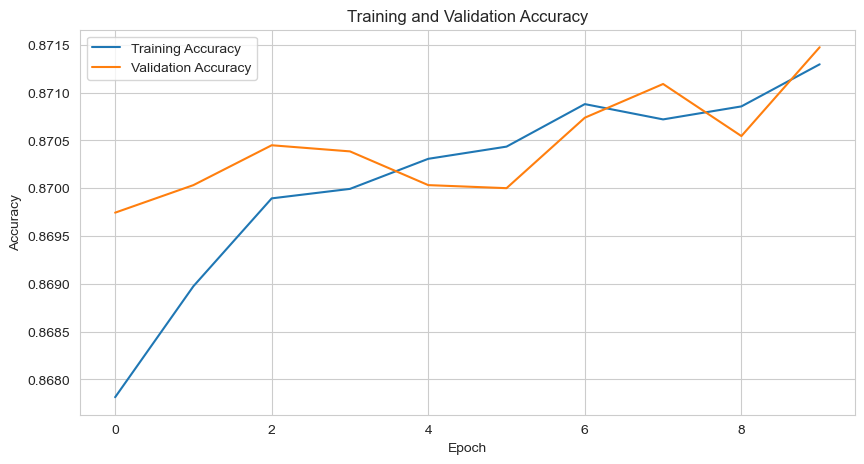

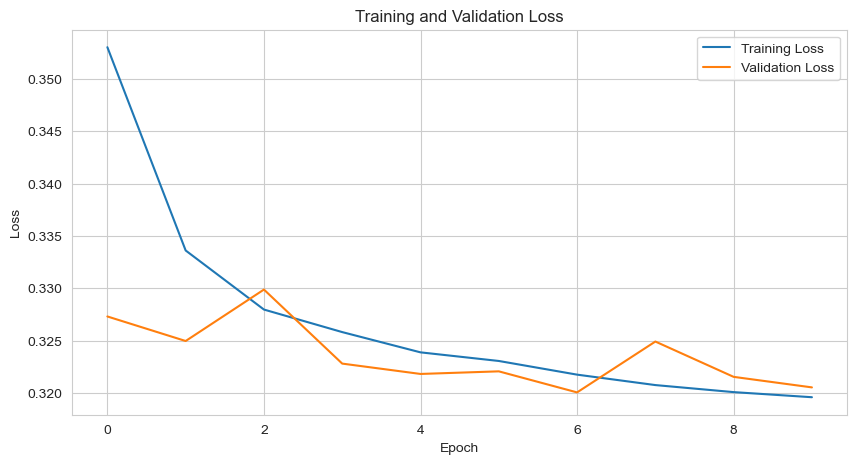

In [241]:
train_accuracy = history_pretrained.history['binary_accuracy']
val_accuracy = history_pretrained.history['val_binary_accuracy']

train_loss = history_pretrained.history['loss']
val_loss = history_pretrained.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [242]:
test_Y_pt = np.argmax(test_Y, axis=1)
y_pred_prob_pt = model.predict(test_X)
y_pred_pt = np.argmax(y_pred_prob_pt, axis=1)  

32/32 [==============================] - 143s 2s/step


In [243]:
print(classification_report(test_Y_pt, y_pred_pt, target_names=all_labels))

                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       307
      Cardiomegaly       0.00      0.00      0.00        48
     Consolidation       0.00      0.00      0.00        74
             Edema       0.04      0.06      0.05        36
          Effusion       0.00      0.00      0.00       160
         Emphysema       0.00      0.00      0.00        27
          Fibrosis       0.00      0.00      0.00        26
      Infiltration       0.00      0.00      0.00       197
              Mass       0.05      0.82      0.10        50
            Nodule       0.00      0.00      0.00        42
Pleural_Thickening       0.04      0.20      0.07        20
         Pneumonia       0.00      0.00      0.00         4
      Pneumothorax       0.00      0.00      0.00        33

          accuracy                           0.05      1024
         macro avg       0.01      0.08      0.02      1024
      weighted avg       0.00      0.0

In [244]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_Y_pt, y_pred_pt))

[[  0   5   0  10   0   0   0   0 243   0  26   1  22]
 [  0   0   0   3   0   0   0   0  37   0   3   1   4]
 [  0   1   0   6   0   0   0   0  55   0   7   0   5]
 [  0   1   0   2   0   0   0   0  29   0   3   0   1]
 [  0   1   0  12   0   0   0   0 125   0  13   0   9]
 [  0   1   0   1   0   0   0   0  18   0   4   1   2]
 [  0   1   0   1   0   0   0   0  21   0   2   1   0]
 [  0   3   0  13   0   0   0   0 151   0  16   0  14]
 [  0   0   1   1   0   0   0   0  41   0   4   1   2]
 [  0   0   0   1   0   0   0   0  33   0   6   0   2]
 [  0   0   0   1   0   0   0   0  13   0   4   0   2]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0]
 [  0   2   0   1   0   0   0   0  26   0   4   0   0]]


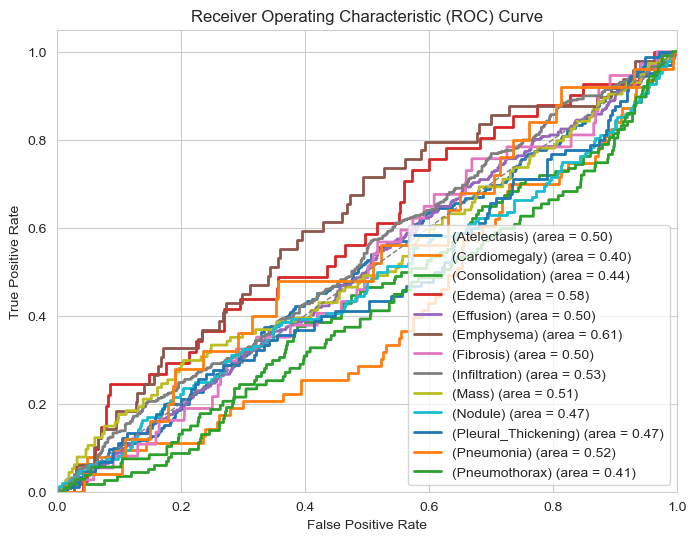

In [245]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(all_labels)):
    fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], y_pred_prob_pt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(all_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label='({}) (area = {:.2f})'.format(all_labels[i], roc_auc[i]))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Using pre-trained model ResNet50

In [57]:
from keras.applications import DenseNet121
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D


# Load the pre-trained DenseNet121 model
base_model_dn = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [58]:
# Set the base model's layers as non-trainable
for layer in base_model_dn.layers:
    layer.trainable = False

In [59]:
x = base_model_dn.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(all_labels), activation='sigmoid')(x)
model_pretrained_dn = Model(inputs=base_model_dn.input, outputs=predictions)

In [60]:
# Compile the model
model_pretrained_dn.compile(optimizer=Adam(lr=0.003), 
                         loss='binary_crossentropy', 
                         metrics=['binary_accuracy'])

In [61]:
model_pretrained_dn.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_9[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 pool4_bn (BatchNormalizati  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 on)      

 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 608)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 7, 7, 128)            77824     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block4_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv5_block8_0_bn (BatchNo  (None, 7, 7, 736)            2944      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 736)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 7, 7, 128)            94208     ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block8_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block8_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 864)            3456      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 7, 7, 864)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 7, 7, 128)            110592    ['conv5_block12_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 992)            3968      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 7, 7, 992)            0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block16_1_conv (Conv  (None, 7, 7, 128)            126976    ['conv5_block16_0_relu[0][0]']
 2D)                                                                                              
          

In [62]:
# Train the model
history_pretrained_dn = model_pretrained_dn.fit(train_generator,
                                epochs=10,
                                steps_per_epoch=50,
                                validation_data=valid_generator,
                                validation_steps=valid_steps_per_epoch,
                                verbose=1)

Epoch 1/10
50/50 [==============================] - 444s 8s/step - loss: 0.4019 - binary_accuracy: 0.8455 - val_loss: 0.3422 - val_binary_accuracy: 0.8688
Epoch 2/10
50/50 [==============================] - 411s 8s/step - loss: 0.3537 - binary_accuracy: 0.8654 - val_loss: 0.3374 - val_binary_accuracy: 0.8684
Epoch 3/10
50/50 [==============================] - 385s 8s/step - loss: 0.3466 - binary_accuracy: 0.8679 - val_loss: 0.3362 - val_binary_accuracy: 0.8685
Epoch 4/10
50/50 [==============================] - 383s 8s/step - loss: 0.3481 - binary_accuracy: 0.8669 - val_loss: 0.3337 - val_binary_accuracy: 0.8700
Epoch 5/10
50/50 [==============================] - 386s 8s/step - loss: 0.3465 - binary_accuracy: 0.8661 - val_loss: 0.3365 - val_binary_accuracy: 0.8697
Epoch 6/10
50/50 [==============================] - 428s 9s/step - loss: 0.3415 - binary_accuracy: 0.8693 - val_loss: 0.3319 - val_binary_accuracy: 0.8701
Epoch 7/10
50/50 [==============================] - 417s 8s/step - los

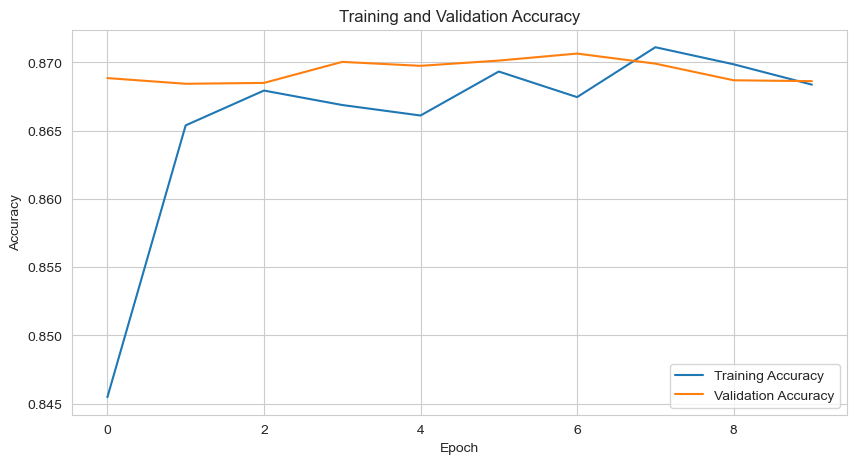

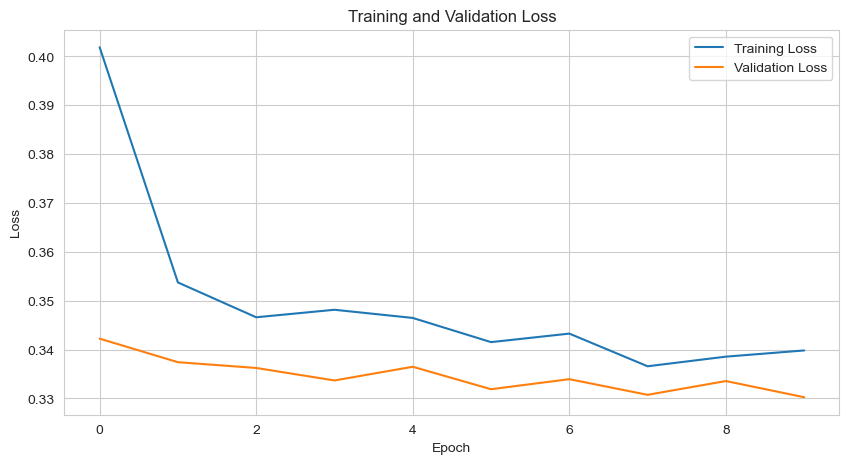

In [63]:
train_accuracy = history_pretrained_dn.history['binary_accuracy']
val_accuracy = history_pretrained_dn.history['val_binary_accuracy']

train_loss = history_pretrained_dn.history['loss']
val_loss = history_pretrained_dn.history['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()